# Corporate Tax Rates and the Largest Stock Exchanges

# ETL

### Import Utils

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.linear_model import LinearRegression

### Import Data

Import key index from each countries largest stock exchange

In [485]:
bse_index    = pd.read_csv('BSE.index.bse.csv')
ftse_index   = pd.read_csv('FTSE.index.GBP.csv')
gdaxi_index  = pd.read_csv('GDAXI.index.eur.csv')
gsptse_index = pd.read_csv('GSPTSE.composite.cad.csv')
hsi_index    = pd.read_csv('HSI.index.hkd.csv')
kospi_index  = pd.read_csv('KOSPI.composite.krw.csv')
n225_index   = pd.read_csv('N225.index.jpy.csv')
nya_index    = pd.read_csv('NYA.composite.usd.csv')
sse_index    = pd.read_csv('SSE.composite.csy.csv')
ssmi_index   = pd.read_csv('SSMI.index.chf.csv')

Import corporate tax rates, inflation, and unemployment sourced from yahoo finance and the world bank.

In [486]:
corporate_tax_rates = pd.read_excel('corporate.tax.rates.xlsx')
inflation_rates     = pd.read_csv('inflation.csv')
unemployment_rates  = pd.read_csv('unemployment rate.csv')

# Data Preperation

### Corporate Tax Rates Data Quality Check and Tranformation

First, we check to make sure that the data was imported correctly.

In [487]:
corporate_tax_rates.head()

,iso_2,iso_3,continent,country,year,rate,gdp,oecd,eu27,gseven,gtwenty,brics
0,AW,ABW,NO,Aruba,1980,NaN,NaN,0,0,0,0,0
1,AW,ABW,NO,Aruba,1981,NaN,NaN,0,0,0,0,0
2,AW,ABW,NO,Aruba,1982,NaN,NaN,0,0,0,0,0
3,AW,ABW,NO,Aruba,1983,NaN,NaN,0,0,0,0,0
4,AW,ABW,NO,Aruba,1984,NaN,NaN,0,0,0,0,0


Next, we filter the `corporate tax rates` data removing country grouping data, and keeping only our chosen countries.

In [488]:
corporate_tax_rates = corporate_tax_rates.drop(columns=['iso_2','iso_3','continent','oecd','eu27','gseven','gtwenty','brics'])

country_list = ['United States of America','India','United Kingdom of Great Britain and Northern Ireland','Germany','Canada','China, Hong Kong Special Administrative Region','Republic of Korea','Japan','China','Switzerland']

filtered_corporate_tax_rates = corporate_tax_rates[corporate_tax_rates['country'].isin(country_list)]

ctr = filtered_corporate_tax_rates

ctr

,country,year,rate,gdp
1640,Canada,1980,NaN,781.317688
1641,Canada,1981,50.920000,808.688171
1642,Canada,1982,49.530000,782.793823
1643,Canada,1983,48.270000,803.135254
1644,Canada,1984,47.630000,850.723816
...,...,...,...,...
9671,United States of America,2016,38.923934,16972.345703
9672,United States of America,2017,38.906474,17348.623047
9673,United States of America,2018,25.838580,17844.271484
9674,United States of America,2019,25.886141,18290.378906


Finally, we check for missing values in `corporate_tax_rates`.

In [489]:
ctr.isnull().sum()

country     0
year        0
rate       30
gdp         0
dtype: int64

### Inflation Rates Data Quality Check and Tranformation

First, we look at inflation rates data to make sure it was imported properly.

In [490]:
inflation_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.971206,9.158707,5.746949,5.370290,5.250171,6.594604,6.399343,4.720811,3.923372,4.978097
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.018699,4.578375,2.439201,1.758052,2.130268,1.494564,1.764635,1.481021,1.758565,2.425007
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.482468,10.277905,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN


Next, we filter inflation rates data removing columns that don't include data that we need like `Country Code`, `Indicator Name`, and `Indicator Code`.

In [491]:
country_list = ['United States','India','United Kingdom','Germany','Canada','Hong Kong SAR, China','Korea, Rep.','Japan','China','Switzerland']

filtered_inflation_rates = inflation_rates[ inflation_rates['Country Name'].isin(country_list) ]

ir = filtered_inflation_rates.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

ir

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
35,Canada,1.358696,1.018767,1.061571,1.628151,1.912145,2.332657,3.815659,3.579952,4.055300,...,2.912135,1.515678,0.938292,1.906636,1.125241,1.428760,1.596884,2.268226,1.949269,0.717000
37,Switzerland,1.438795,1.845398,4.315993,3.440213,3.080557,3.414479,4.775980,4.005196,2.395822,...,0.231349,-0.692552,-0.217323,-0.013203,-1.143909,-0.434619,0.533788,0.936335,0.362886,-0.725875
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.553899,2.619524,2.621050,1.921642,1.437024,2.000002,1.593136,2.074790,2.899234,2.419422
55,Germany,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,3.533059,1.796046,1.470304,...,2.075175,2.008491,1.504721,0.906798,0.514421,0.491749,1.509497,1.732168,1.445667,0.506690
81,United Kingdom,1.003576,3.447496,4.196499,2.018544,3.281587,4.773775,3.909618,2.482116,4.697428,...,3.856112,2.573235,2.291667,1.451120,0.368047,1.008417,2.557756,2.292840,1.738105,0.989487
96,"Hong Kong SAR, China",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.276561,4.063861,4.323570,4.438503,2.995392,2.411136,1.480583,2.407717,2.864928,0.325437
109,India,1.779878,1.695213,3.632215,2.946161,13.355261,9.474759,10.801848,13.062202,3.237412,...,8.858361,9.312446,11.063675,6.649500,4.906973,4.948216,3.328173,3.945069,3.723276,6.623437
119,Japan,3.574512,5.368462,6.835440,6.706906,3.800389,6.655991,5.040832,3.989848,5.339433,...,-0.267634,-0.051939,0.346440,2.761954,0.789518,-0.116667,0.467212,0.979904,0.476974,-0.016369
126,"Korea, Rep.",7.965578,8.195649,6.618318,20.691629,29.462816,13.548203,11.261386,10.882442,10.771820,...,4.025846,2.187221,1.301377,1.274715,0.706208,0.971675,1.944456,1.475862,0.382946,0.537258
251,United States,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,...,3.156842,2.069337,1.464833,1.622223,0.118627,1.261583,2.130110,2.442583,1.812210,1.233584


Finally, we check to see if there is any missing data.

In [492]:
ir.isnull().sum()

Country Name    0
1960            2
1961            2
1962            2
1963            2
               ..
2016            0
2017            0
2018            0
2019            0
2020            0
Length: 62, dtype: int64

### Unemployment Rates Data Quality Check and Transformation

First, we check that the data was imported successfully.

In [493]:
unemployment_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.730720,6.578243,6.480673,6.414462,6.468598,6.546351,6.523061,6.414392,6.472269,6.814177
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,11.510000,11.520000,11.540000,11.450000,11.390000,11.310000,11.180000,11.060000,10.980000,11.730000
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.466731,4.560139,4.356187,4.640632,4.547113,5.486480,5.927104,5.910615,5.928926,6.300105
4,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.360000,7.370000,7.380000,7.310000,7.260000,7.200000,7.100000,7.000000,6.930000,7.700000


Next, we narrow down our data to our selected countries.

In [494]:
country_list = ['United States','India','United Kingdom','Germany','Canada','Hong Kong SAR, China','Korea, Rep.','Japan','China','Switzerland']

filtered_unemployment_rates = unemployment_rates[ unemployment_rates['Country Name'].isin(country_list) ]

ur = filtered_unemployment_rates.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

ur

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
35,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.51,7.29,7.07,6.91,6.91,7.00,6.34,5.83,5.66,9.48
37,Switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.40,4.49,4.75,4.83,4.80,4.92,4.80,4.71,4.39,4.94
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.50,4.60,4.60,4.60,4.60,4.50,4.40,4.30,4.60,5.00
55,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.82,5.38,5.23,4.98,4.62,4.12,3.75,3.38,3.14,4.31
81,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.04,7.89,7.52,6.11,5.30,4.81,4.33,4.00,3.74,4.34
96,"Hong Kong SAR, China",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.42,3.29,3.40,3.30,3.32,3.39,3.09,3.04,2.96,5.80
109,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.65,5.66,5.67,5.60,5.56,5.51,5.41,5.33,5.27,7.11
119,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.52,4.30,4.00,3.60,3.40,3.10,2.80,2.40,2.40,2.97
126,"Korea, Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.40,3.20,3.10,3.50,3.55,3.65,3.65,3.82,3.75,4.07
251,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.95,8.07,7.38,6.17,5.28,4.87,4.36,3.90,3.67,8.31


Finally, check for any missing values

In [495]:
ur.isnull().sum()

Country Name     0
1960            10
1961            10
1962            10
1963            10
                ..
2016             0
2017             0
2018             0
2019             0
2020             0
Length: 62, dtype: int64

# Data Exploration

### GDP vs Year

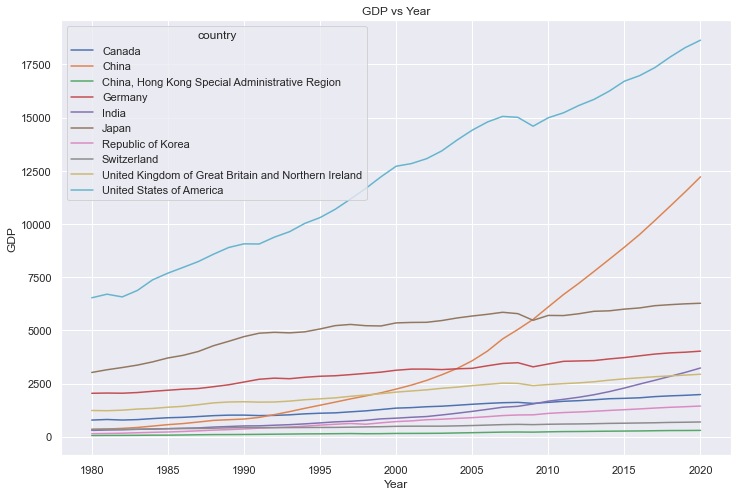

In [496]:
_ = ctr.pivot_table(values='gdp', index='year', columns='country').plot(figsize=(12,8))

_ = plt.xlabel('Year')
_ = plt.ylabel('GDP')

_ = plt.title('GDP vs Year')

plt.show()

### Inflation Rate vs Year
It is generally much simpler to perform calculations on tall format data so we melt our `ir` data frame.

In [497]:
years = [ str(x) for x in range(1960,2021)]

ir = ir.melt( id_vars=['Country Name'], value_vars=years, )
ir = ir.sort_values(by=['Country Name', 'variable'])

ir

,Country Name,variable,value
0,Canada,1960,1.358696
10,Canada,1961,1.018767
20,Canada,1962,1.061571
30,Canada,1963,1.628151
40,Canada,1964,1.912145
...,...,...,...
569,United States,2016,1.261583
579,United States,2017,2.130110
589,United States,2018,2.442583
599,United States,2019,1.812210


Then we use pandas build in plot function to create a line plot by country.

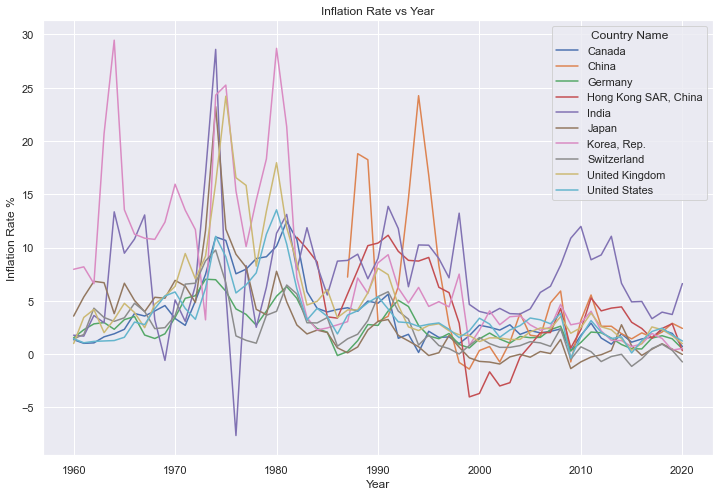

In [498]:
_ = ir.pivot_table(values='value', index='variable', columns='Country Name').plot(figsize=(12,8))

_ = plt.xlabel('Year')
_ = plt.ylabel('Inflation Rate %')

_ = plt.title('Inflation Rate vs Year')

plt.show()

### Unemployment Rate vs Year
Just as we had with the inflation rate data, we `melt` our data frame so that it is in tall form.

In [499]:
years = [ str(x) for x in range(1960,2021) ]

ur = ur.melt( id_vars=['Country Name'], value_vars=years, )
ur = ur.sort_values(by=['Country Name', 'variable'])

ur

,Country Name,variable,value
0,Canada,1960,NaN
10,Canada,1961,NaN
20,Canada,1962,NaN
30,Canada,1963,NaN
40,Canada,1964,NaN
...,...,...,...
569,United States,2016,4.87
579,United States,2017,4.36
589,United States,2018,3.90
599,United States,2019,3.67


We then use the build in plot function in pandas to plot the inflation rate by year and country.

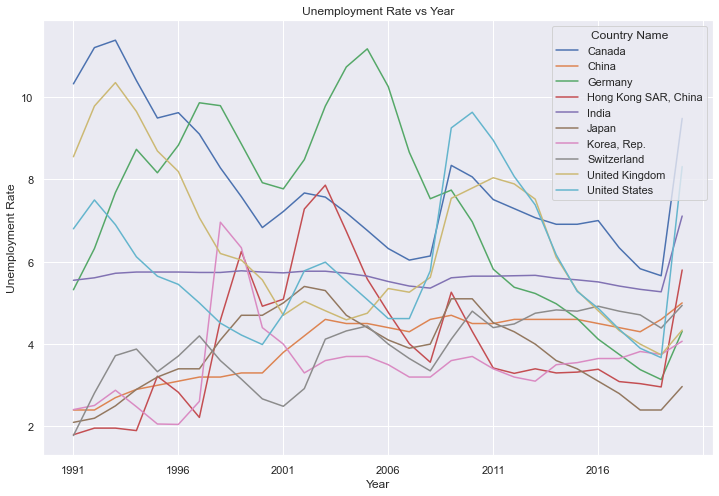

In [500]:
_ = ur.pivot_table(values='value', index='variable', columns='Country Name').plot(figsize=(12,8))

_ = plt.xlabel('Year')
_ = plt.ylabel('Unemployment Rate')

_ = plt.title('Unemployment Rate vs Year')

plt.show()

In [501]:
# get unemployment data for US
ur_us = ur[ ur['Country Name'] == 'United States' ]
# select 1980+
ur_us = ur_us[ ur_us['variable'] >= '1991']
# rename
ur_us = ur_us.rename( columns={ 'variable':'year', 'value':'ur' } ) 
# get percentage change
ur_us['change'] = ur_us['ur'].pct_change()
# trim unemployment (there is not change in 1991)
ur_us = ur_us.iloc[1:, :]
# convert integers
ur_us.astype( 
  dtype={
    'ur':'int32',
    'change':'int32'
  }
)


# gdp data for us
gdp_us = ctr[ ctr['country'] == 'United States of America' ]
# get gdp 1980+
gdp_us = gdp_us[ gdp_us['year'] >= 1991 ]
# get rate of change
gdp_us['gdp_change'] = gdp_us['gdp'].pct_change()
# cut off before 1991 (to match with ur data)
gdp_us = gdp_us.iloc[1:, :]


In [502]:
# check that datasets have the same number of rows
print( "US Unemployment Data")
print( ur_us.shape )
print( ur_us.isnull().sum() )
print( "US GDP Data")
print( gdp_us.shape )
print( gdp_us.isnull().sum() )


US Unemployment Data
(29, 4)
Country Name    0
year            0
ur              0
change          0
dtype: int64
US GDP Data
(29, 5)
country       0
year          0
rate          0
gdp           0
gdp_change    0
dtype: int64


In [503]:
# run regression to test if unemployment is a predictor of gdp

x = ur_us['change'].values.reshape(-1,1)
y = gdp_us['gdp_change'].values.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit( x, y )  # perform linear regression

y_predict = linear_regressor.predict( x )

print(linear_regressor.score( x, y ))

print(linear_regressor.coef_)



0.2315338513814159
[[-0.02576194]]


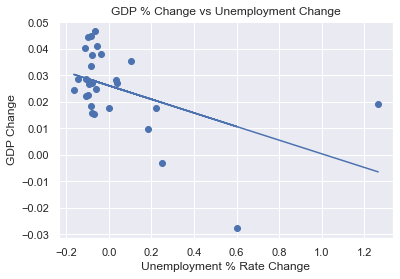

In [504]:
_ = plt.scatter( x, y )

_ = plt.title('GDP % Change vs Unemployment Change')

_ = plt.xlabel('Unemployment % Rate Change')
_ = plt.ylabel('GDP Change')

_ = plt.plot( x, y_predict )

plt.show()

Given that there is an outier we want to see if it could be explained with the stock exchange data. Run a test on the unemployment rate data to find outliers.

In [505]:
def get_outliers( column ):
  q1 = np.percentile( column, 25 )
  q3 = np.percentile( column, 75 )

  iqr = q3 - q1

  upper_bound = q3 + ( 1.5 * iqr )
  lower_bound = q1 - ( 1.5 * iqr )

  lower_outliers = column < lower_bound
  upper_outliers = column > upper_bound

  return lower_outliers, upper_outliers


lower_outliers = ur_us[ get_outliers( ur_us['change'] )[0] ]
upper_outliers = ur_us[ get_outliers( ur_us['change'] )[1] ]

print(lower_outliers)
print(upper_outliers)



Empty DataFrame
Columns: [Country Name, year, ur, change]
Index: []
      Country Name  year    ur    change
489  United States  2008  5.78  0.251082
499  United States  2009  9.25  0.600346
609  United States  2020  8.31  1.264305


Given these outliers, we can try to explain them with stock market data.

In [506]:
nya_index.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-02,641.719971,641.719971,641.719971,641.719971,641.719971,0
1,1980-01-03,638.020020,638.020020,638.020020,638.020020,638.020020,0
2,1980-01-04,646.799988,646.799988,646.799988,646.799988,646.799988,0
3,1980-01-07,649.229980,649.229980,649.229980,649.229980,649.229980,0
4,1980-01-08,661.809998,661.809998,661.809998,661.809998,661.809998,0


In [507]:
# slice needed data
nya_date_open = nya_index[ ['Date', 'Open' ] ]
# convert open data to int
nya_date_open.astype( 
  dtype={
    'Open':'int32',
  }
)

# create year colum
nya_date_open['Year'] = nya_date_open['Date'].map( lambda x: x[0:4] )
# get data that is later than 1991
nya_date_open = nya_date_open[ nya_date_open['Year'] >= '1992' ]
# group by the year to match with other data
nya_year_open = nya_date_open[ ['Year', 'Open'] ].groupby(['Year']).mean().reset_index()

nya_year_open.head()

<ipython-input-507-698dfb945ab8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nya_date_open['Year'] = nya_date_open['Date'].map( lambda x: x[0:4] )


,Year,Open
0,1992,2421.434367
1,1993,2640.258735
2,1994,2687.394808
3,1995,3078.884677
4,1996,3785.552563


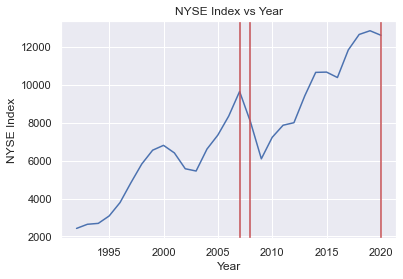

In [516]:
_ = plt.plot( nya_year_open['Year'], nya_year_open['Open'] )

_ = plt.title('NYSE Index vs Year')

_ = plt.xlabel('Year')
_ = plt.ylabel('NYSE Index')

_ = plt.xticks([
  '1995',
  '2000',
  '2005',
  '2010',
  '2015',
  '2020'
])

_ = plt.axvline(x='2007', color='r')
_ = plt.axvline(x='2008', color='r')
_ = plt.axvline(x='2020', color='r')

plt.show()